In [1]:
import urllib.request
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import csv
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from ipywidgets import widgets, interactive

In [2]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

# Fire Emblem: Heroes Character Analysis

## Introduction

In this project, we will be taking a look at character data from the popular mobile game *Fire Emblem: Heroes* available on iPhone and Android. Fire Emblem, a strategy RPG franchise developed by Intelligent System, added this mobile game to its list of entries following the popularity of recent titles *Fire Emblem: Awakening* and *Fire Emblem: Fates* for the 3DS. In this entry, you are in the position of a tactician, deploying up to four characters from the Fire Emblem Universe to do battle against the opposing enemy team. The game utilizes a rock-paper-scissors battle mechanic, with some weapons being superior to others. 

Like many popular mobile games, *Fire Emblem: Heroes* is a free-to-play Gacha game, where characters are drawn from a random pool, each with varying rarity and power. 

## Web-Scraping

We begin this project by obtaining the character data, using data hosted on gamepedia.com (I do not own the data).

In [3]:
class AppURLopener(urllib.request.FancyURLopener):
    version = "Mozilla/5.0"

opener = Request("https://feheroes.gamepedia.com/Stats_Table",
                headers = {"User-Agent": "Mozilla/5.0"})

# query the website and return the html to the variable 'webpage'

webpage = urlopen(opener).read()

# parse the html using beautiful soup and store in variable 'soup'
soup = BeautifulSoup(webpage, 'html.parser')

In [4]:
# Take out the <div> of name and get its value
right_table=soup.find('table', id = "max-stats-table")
length = len(right_table.findAll("tr"))

# variable placeholders for respective column info for data frame
name = []
color = []
weapon_type = []
mov_type = []
hp = []
atk = []
spd = []
defense = []
res = []
total = []

#inserting values into the placeholders
i = 0
for row in right_table.findAll("tr"):
    if i == 0:
        i += 1
        continue
    val = []
    val = row["data-weapon-type"].split()
    color.append(val[0])
    weapon_type.append(val[1])
    mov_type.append(row["data-move-type"])
    cells = row.findAll('td')
    name.append(cells[0].findAll('a')[0]["title"])
    hp.append(int(cells[4].find(text=True)))
    atk.append(int(cells[5].find(text=True)))
    spd.append(int(cells[6].find(text=True)))
    defense.append(int(cells[7].find(text=True)))
    res.append(int(cells[8].find(text=True)))
    total.append(int(cells[9].find(text=True)))

In [5]:
# creating the data frame using pandas
df = pd.DataFrame(name,columns=['Name'])
df["Color"] = color
df['Weapon Type'] = weapon_type
df['Movement Type'] = mov_type
df['HP'] = hp
df['Attack'] = atk
df['Speed'] = spd
df['Defense'] = defense
df['Resistance'] = res
df['Total'] = total

This gives us a dataframe that details the battle-related statistics of each character, including their weapon type, movement type, and the values for each of their stats.

We will take a look at the dataframe for all the renditions of the character named Ike from *Fire Emblem: Path of Radiance* and *Fire Emblem: Radiant Dawn*.

In [7]:
df[df['Name'].str.contains("Hector")]

,Name,Color,Weapon Type,Movement Type,HP,Attack,Speed,Defense,Resistance,Total
149,Hector: Brave Warrior,Blue,Lance,Armored,48,37,22,39,28,174
150,Hector: Dressed-Up Duo,Red,Sword,Armored,47,41,26,39,27,180
151,Hector: General of Ostia,Green,Axe,Armored,52,36,24,37,19,168
152,Hector: Just Here to Fight,Green,Axe,Armored,50,38,21,40,24,173
153,Hector: Marquess of Ostia,Green,Axe,Armored,47,40,23,38,26,174


However, there's more data that is involved with each character. We also would like to obtain information regarding what Fire Emblem game they are from originally, when the character was first introduced into FE Heroes, what rarities they are available at, how they can be obtained in the game, and whether they are one of the distinct "Legendary Heroes" or not (we will be doing an analysis on them later). We will be using another link from gamepedia.com to do so:

In [8]:
#grab universe from link
    
opener2 = Request("https://feheroes.gamepedia.com/Hero_list",
        headers = {"User-Agent": "Mozilla/5.0"})

# query the website and return the html to the variable 'webpage'

universe = urlopen(opener2).read()

# parse the html using beautiful soup and store in variable 'soup'
uni = BeautifulSoup(universe, 'html.parser')

left_table=uni.find('table')
length = len(left_table.findAll("tr"))

# variable placeholders for respective column info for data frame
nombre = []
origin = []
col = []
weap_type = []
move_type = []
rarities = []
st_tt = []
release = []
lgd = []

tab_vals = left_table.findAll("tr")

for ind in range(1, len(tab_vals)):
    val = []
    val = tab_vals[ind]["data-weapon-type"].split()
    cells = tab_vals[ind].findAll("td")
    
    nombre.append(cells[1].findAll('a')[0]["title"])
    origin.append(cells[2].find(text=True))
    rare = (cells[5].findAll(text=True))
    add = []
    legend = False
    for i in np.arange(len(rare)):
        app = "None"
        if str(rare[i]).find("–") != -1:
            rare[i] = str(rare[i]).replace("–", "")
        if rare[i].find(" ") != -1:
            rare[i] = str(rare[i]).replace(" ", "")
        if rare[i] == "TempestTrials":
            app = "Tempest Trials"
        if rare[i] == "GrandHeroBattle":
            app = "Grand Hero Battle"
        if rare[i] == "Story":
            app = "Story"
        if i + 1 == len(rare):
            st_tt.append(app)
        if rare[i] in ("3", "4", "5"):
            add.append(int(rare[i]))
        if rare[i] == "Legendary":
            legend = True
    lgd.append(legend)
    rarities.append(add)
    release.append(cells[6].find(text=True))
    
    
# creating the data frame using pandas
df2 = pd.DataFrame(nombre,columns=['Name'])
df2["Origin"] = origin
df2['Rarities'] = rarities
df2['Story/TT/GHB?'] = st_tt
df2['Release Date'] = release
df2["Legendary"] = lgd

Now we have our second dataframe which, when running the cell below, looks like this:

In [9]:
with pd.option_context('display.max_rows', 5, 'display.max_columns', 100):
    display(df2)

,Name,Origin,Rarities,Story/TT/GHB?,Release Date,Legendary
0,Abel: The Panther,Fire Emblem: Mystery of the Emblem,"[3, 4]",None,2017-02-02,False
1,Alfonse: Prince of Askr,Fire Emblem Heroes,[4],Story,2017-02-02,False
...,...,...,...,...,...,...
438,Zelgius: Jet-Black General,Fire Emblem: Radiant Dawn,[5],None,2018-01-12,False
439,Zephiel: The Liberator,Fire Emblem: The Binding Blade,"[3, 4]",Grand Hero Battle,2017-04-20,False


In [19]:
df2["Origin"].unique()

array(['Fire Emblem: Mystery of the Emblem', 'Fire Emblem Heroes',
       'Fire Emblem Echoes: Shadows of Valentia',
       'Fire Emblem: The Sacred Stones',
       'Fire Emblem: Genealogy of the Holy War', 'Fire Emblem Fates',
       'Fire Emblem: New Mystery of the Emblem', 'Fire Emblem Awakening',
       'Fire Emblem: The Binding Blade', 'Fire Emblem: Path of Radiance',
       'Fire Emblem: Three Houses', 'Fire Emblem: Radiant Dawn',
       'Fire Emblem: The Blazing Blade', 'Fire Emblem: Thracia 776',
       'Fire Emblem: Shadow Dragon and the Blade of Light'], dtype=object)

And then we merge the two dataframes together to create a dataframe called "heroes", which contains all of the available data on each character. The following cell will both merge the two dataframes together, as well as give us the first five rows of our new dataframe.

In [12]:
heroes = pd.merge(df2, df, on = "Name")
heroes.head()
#with pd.option_context('display.max_rows', None, 'display.max_columns', 100):
#    display(heroes)

,Name,Origin,Rarities,Story/TT/GHB?,Release Date,Legendary,Color,Weapon Type,Movement Type,HP,Attack,Speed,Defense,Resistance,Total
0,Abel: The Panther,Fire Emblem: Mystery of the Emblem,"[3, 4]",None,2017-02-02,False,Blue,Lance,Cavalry,39,33,32,25,25,154
1,Alfonse: Prince of Askr,Fire Emblem Heroes,[4],Story,2017-02-02,False,Red,Sword,Infantry,43,35,25,32,22,157
2,Alfonse: Spring Prince,Fire Emblem Heroes,[5],None,2018-03-22,False,Green,Axe,Cavalry,41,35,33,30,18,157
3,Alm: Hero of Prophecy,Fire Emblem Echoes: Shadows of Valentia,[5],None,2017-04-14,False,Red,Sword,Infantry,45,33,30,28,22,158
4,Alm: Imperial Ascent,Fire Emblem Echoes: Shadows of Valentia,[5],None,2019-08-16,False,Red,Sword,Infantry,42,38,35,37,20,172


## Data Visualization

In this section, we'll take a deeper look at the data that we just scraped to give ourselves a better idea of what we're working with. Some of the features that we'll be looking at are related to character statistics, weapon type, color, and game origin.

### Stat Distribution

In [13]:
# Make drop down for comparison of unit composition

cat_comp = widgets.Dropdown(
    options=["Weapon Type", "Movement Type", "Color"],
    value="Weapon Type",
    description="Category:",
)

stat_comp = widgets.Dropdown(
    options=["HP", "Attack", "Speed", "Defense", "Resistance"],
    value='HP',
    description='Stat:',
)

def plotit(cat, stat):
    plt.figure(figsize=(8, 5))
    sns.set(style="ticks")
    if cat == "Color":
        sns.violinplot(x= cat, y= stat, data=heroes, palette=["#3498db", "#fe2c54", "#12e193", "#bf77f6"])
    elif cat == "Weapon Type":
        sns.violinplot(x= cat, y= stat, data=heroes, palette="Set3")
    else:
        sns.violinplot(x= cat, y= stat, data=heroes, palette="hls")

interactive(plotit, cat = cat_comp, stat = stat_comp)

interactive(children=(Dropdown(description='Category:', options=('Weapon Type', 'Movement Type', 'Color'), val…

In [14]:
# create a button to allow someone to choose a character and where a certain stat falls in a distribution of that stat
# possibly subset that distribution

#heroes.hist("HP", bins = max(heroes["HP"]) - min(heroes["HP"]))
#len(heroes[heroes["HP"] == 44])

### Character Distribution

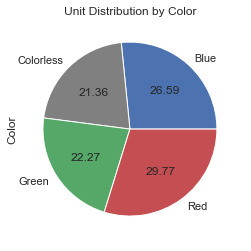

In [15]:
# See the number of characters for each color

colors = heroes.groupby(by="Color").agg(np.size).iloc[:, 6]
colors = colors.rename("Color")
colors.plot.pie(labels=['Blue', 'Colorless', 'Green', 'Red'], colors=['b', 'gray', 'g', 'r'], autopct='%.2f')
plt.title("Unit Distribution by Color")
plt.show()

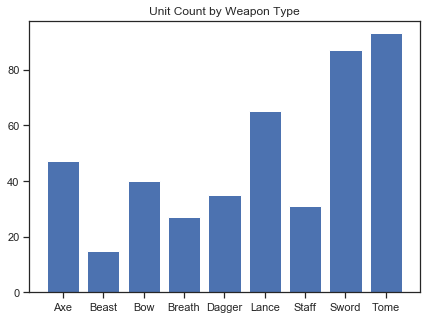

In [16]:
# See the number of characters for each weapon type
plt.figure(figsize=(7, 5))
plt.bar([0, 1, 2, 3, 4, 5, 6, 7, 8], heroes.groupby(by = "Weapon Type").agg(np.size).iloc[:, 0], align = "center")
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], heroes.groupby(by = "Weapon Type").agg(np.size).index)
plt.title("Unit Count by Weapon Type")
plt.show()

We see that characters that use tomes are the most abundant in the game (barely beating out those who use swords). However, we should note that there are three different colors associated with tome users, while sword users are all red. Below we will show a distribution of the color of tome users.

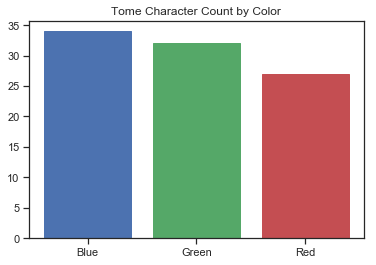

In [17]:
# Tome
tomebar = plt.bar([0, 1, 2], heroes.loc[heroes["Weapon Type"] == "Tome"].groupby(by = "Color").agg(np.size).iloc[:, 0], align = "center")
tomebar[np.where(heroes.loc[heroes["Weapon Type"] == "Tome"].groupby(by = "Color").agg(np.size).index.values == "Red")[0][0]].set_color('r')
tomebar[np.where(heroes.loc[heroes["Weapon Type"] == "Tome"].groupby(by = "Color").agg(np.size).index.values == "Blue")[0][0]].set_color('b')
tomebar[np.where(heroes.loc[heroes["Weapon Type"] == "Tome"].groupby(by = "Color").agg(np.size).index.values == "Green")[0][0]].set_color('g')
plt.xticks([0, 1, 2], heroes.loc[heroes["Weapon Type"] == "Tome"].groupby(by = "Color").agg(np.size).index)
plt.title("Tome Character Count by Color")
plt.show()

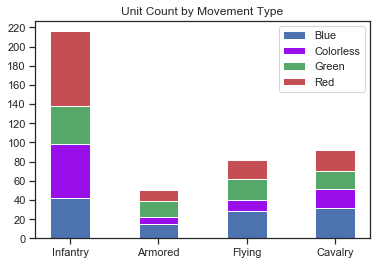

In [18]:
# See the number of characters for each movement type

mov_ty = ["Infantry", "Armored", "Flying", "Cavalry"]
inf = (heroes[heroes["Movement Type"] == mov_ty[0]].groupby(by = "Color").agg(np.size).iloc[:, 0])
arm = (heroes[heroes["Movement Type"] == mov_ty[1]].groupby(by = "Color").agg(np.size).iloc[:, 0])
fly = (heroes[heroes["Movement Type"] == mov_ty[2]].groupby(by = "Color").agg(np.size).iloc[:, 0])
cav = (heroes[heroes["Movement Type"] == mov_ty[3]].groupby(by = "Color").agg(np.size).iloc[:, 0])
inds = heroes[heroes["Movement Type"] == mov_ty[0]].groupby(by = "Color").agg(np.size).index
inds

zos = np.array((inf[0], arm[0], fly[0], cav[0]))
ones = np.array((inf[1], arm[1], fly[1], cav[1]))
twos = np.array((inf[2], arm[2], fly[2], cav[2]))
tres = np.array((inf[3], arm[3], fly[3], cav[3]))

ind = np.arange(4)    
width = 0.45      

p1 = plt.bar(ind, zos, width, color = "b")
p2 = plt.bar(ind, ones, width,  bottom=zos, color = "xkcd:violet")
p3 = plt.bar(ind, twos, width,  bottom= zos + ones, color = "g")
p4 = plt.bar(ind, tres, width, bottom = zos + ones + twos, color = "r")

plt.title("Unit Count by Movement Type")
plt.xticks(ind, ("Infantry", "Armored", "Flying", "Cavalry"))
plt.yticks(np.arange(0, np.sum(inf) + 10, 20))
plt.legend((p1[0], p2[0], p3[0], p4[0]), (inds))

plt.show()

#heroes.groupby(by = "Movement Type").agg(np.size).iloc[:, 0].groupby(by = "Color").agg(np.size).iloc[:, 0]

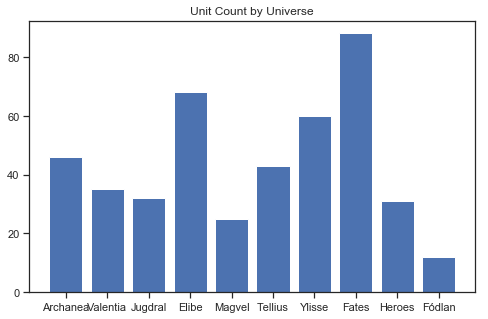

In [22]:
# See the number of characters for each universe
Universes = []

Archanea = len(heroes.loc[heroes["Origin"] == "Fire Emblem: Mystery of the Emblem"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: Shadow Dragon and the Blade of Light"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: New Mystery of the Emblem"])
Valentia = len(heroes.loc[heroes["Origin"] == "Fire Emblem Echoes: Shadows of Valentia"])
Jugdral = len(heroes.loc[heroes["Origin"] == "Fire Emblem: Genealogy of the Holy War"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: Thracia 776"])
Elibe = len(heroes.loc[heroes["Origin"] == "Fire Emblem: The Blazing Blade"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: The Binding Blade"])
Magvel = len(heroes.loc[heroes["Origin"] == "Fire Emblem: The Sacred Stones"])
Tellius = len(heroes.loc[heroes["Origin"] == "Fire Emblem: Path of Radiance"]) \
+ len(heroes.loc[heroes["Origin"] == "Fire Emblem: Radiant Dawn"])
Ylisse = len(heroes.loc[heroes["Origin"] == "Fire Emblem Awakening"])
Fates = len(heroes.loc[heroes["Origin"] == "Fire Emblem Fates"])
Heroes = len(heroes.loc[heroes["Origin"] == "Fire Emblem Heroes"])
threeH = len(heroes.loc[heroes["Origin"] == "Fire Emblem: Three Houses"])
     
Universes.append(Archanea)
Universes.append(Valentia)
Universes.append(Jugdral)
Universes.append(Elibe)      
Universes.append(Magvel)
Universes.append(Tellius)
Universes.append(Ylisse)
Universes.append(Fates)
Universes.append(Heroes)
Universes.append(threeH)

plt.figure(figsize=(8, 5))
plt.bar(np.arange(10), Universes, align = "center")
plt.xticks(np.arange(10), ["Archanea", "Valentia", "Jugdral", "Elibe", "Magvel", "Tellius", 
                          "Ylisse", "Fates", "Heroes", "Fódlan"])
plt.title("Unit Count by Universe")
plt.show()

## Save to CSV

The cell below will save the data that we've scraped and processed into a .csv file that can be used for future analysis.

In [23]:
heroes.to_csv("hero_data.csv", encoding='utf-8', index=False)

## Coming Soon: Is the Power-Creep Real?

One of the most annoying things about gacha games is that you spend time grooming and building a character that you really like and is good at the time, only for it to be trumped a few months later by a new character of similar build but better in more ways than one. With the ever-growing list of characters in FE Heroes, it's more than likely that old favorites have been subjected to the "power creep", and the ones that are the most popular today will be left in the dust in a few iterations of characters.

In [151]:
heroes[heroes["Release Date"] == "2017-02-02"]

,Name,Origin,Rarities,Story/TT/GHB?,Release Date,Legendary,Color,Weapon Type,Movement Type,HP,Attack,Speed,Defense,Resistance,Total
0,Abel: The Panther,Fire Emblem: Mystery of the Emblem,"[3, 4]",None,2017-02-02,False,Blue,Lance,Cavalry,39,33,32,25,25,154
1,Alfonse: Prince of Askr,Fire Emblem Heroes,[4],Story,2017-02-02,False,Red,Sword,Infantry,43,35,25,32,22,157
6,Anna: Commander,Fire Emblem Heroes,[4],Story,2017-02-02,False,Green,Axe,Infantry,41,29,38,22,28,158
9,Arthur: Hapless Hero,Fire Emblem Fates,"[3, 4]",None,2017-02-02,False,Green,Axe,Infantry,43,32,29,30,24,158
14,Azama: Carefree Monk,Fire Emblem Fates,"[3, 4]",None,2017-02-02,False,Colorless,Staff,Infantry,43,21,26,32,25,147
17,Azura: Lady of the Lake,Fire Emblem Fates,[5],None,2017-02-02,False,Blue,Lance,Infantry,36,31,33,21,28,149
20,Barst: The Hatchet,Fire Emblem: Mystery of the Emblem,"[3, 4]",None,2017-02-02,False,Green,Axe,Infantry,46,33,32,30,17,158
21,Bartre: Fearless Warrior,Fire Emblem: The Binding Blade,"[3, 4]",None,2017-02-02,False,Green,Axe,Infantry,49,36,25,33,13,156
24,Beruka: Quiet Assassin,Fire Emblem Fates,"[3, 4]",None,2017-02-02,False,Green,Axe,Flying,46,29,23,37,22,157
30,Caeda: Talys's Heart,Fire Emblem: Mystery of the Emblem,"[3, 4]",None,2017-02-02,False,Red,Sword,Flying,36,25,37,24,34,156
